# Tutorial 6: Galactic Binaries & RJMCMC

In the sixth tutorial, we will examine Galactic Binary waveforms. We will then use them in fixed-dimensional MCMC and then in RJMCMC. We use RJMCMC to perform model selection on the number of sources in the data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful
from lisatools.utils.constants import *

## Task 1: Build and plot a Galacic Binary waveform using `GBGPU`

In [2]:
# imports
from gbgpu.gbgpu import GBGPU

In [3]:
gb = GBGPU()

(0.003999, 0.004001)

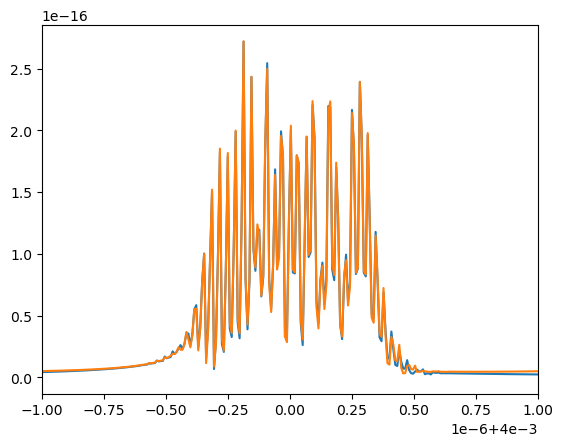

In [56]:
amp = 1e-22
f0 = 4e-3
fdot = 1e-17
fddot = 0.0
phi0 = 2.3
inc = np.pi/5.23232
psi = 2.980322
lam = 4.05934323
beta = 0.623121
Tobs = YRSID_SI
gb.run_wave(amp, f0, fdot, fddot, phi0, inc, psi, lam, beta, N=16384)  # T=Tobs, oversample=4)
plt.plot(gb.freqs[0], np.abs(gb.A[0]))
gb.run_wave(amp, f0, fdot, fddot, phi0, inc, psi, lam, beta, N=256)  # T=Tobs, oversample=4)

plt.plot(gb.freqs[0], np.abs(gb.A[0]))
plt.xlim(0.003999, 0.004001)

## Task 2: Run an MCMC over 

In [91]:
from eryn.prior import uniform_dist, ProbDistContainer

In [143]:
priors = {"gb": ProbDistContainer({
    0: uniform_dist(1e-23, 1e-21),
    1: uniform_dist(0.003995, 0.004005),
    2: uniform_dist(1e-18, 1e-17),
    3: uniform_dist(0.0, 2 * np.pi),
    4: uniform_dist(0.0, np.pi),  # should be over cosine of inclination, but this is simpler for examples
    5: uniform_dist(0.0, np.pi)
})}
lam = 4.13
beta = -0.15

# [lam, beta] of galactic center
default_values = np.array([lam, beta])


In [144]:
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray
from lisatools.sensitivity import AE1SensitivityMatrix

In [179]:
N_wave = 256
def like_wrap(x, analysis1, data, fd, Tobs, dt, default_values):
    input_parameters = np.zeros(9)
    input_parameters[np.array([0, 1, 2, 4, 5, 6])] = x
    input_parameters[np.array([7, 8])] = default_values
    # print(input_parameters)
    gb.run_wave(*input_parameters, T=Tobs, dt=dt, N=N_wave)  # T=Tobs, oversample=4)
    
    A = gb.A[0]
    E = gb.E[0]
    # print(A[::100], check[0][::100])
    # print(gb.freqs[0][::100], check_freqs[::100])

    start_ind = int(gb.freqs[0][0] / df)
    template = DataResidualArray(np.array([A, E]), f_arr=gb.freqs[0])
    data_tmp = DataResidualArray(data[:, start_ind:start_ind + N_wave], f_arr=fd[start_ind:start_ind + N_wave])
    sens_mat = AE1SensitivityMatrix(data_tmp.f_arr)
    analysis = AnalysisContainer(data_tmp, sens_mat)
    # fig, ax = data_tmp.loglog()
    # print(data_tmp.shape)
    # plt.show()
    # template.loglog()
    # plt.show()
    ll = analysis.template_likelihood(template)
    return ll

In [180]:
injection_params = np.array([
    amp, 
    f0,
    fdot,
    0.0,
    phi0,
    inc,
    psi,
    lam,
    beta
])
print(injection_params)

Tobs = YRSID_SI
dt = 5.0
N = int(Tobs / dt)
Tobs = N * dt
df = 1 / Tobs
# TODO: fix DataREsidualArray frequency check error here with df=
f_arr = np.arange(0.0, 1/(2 * dt) + df, df)
data_orig = np.asarray(gb.inject_signal(*injection_params, T=Tobs, dt=dt, N=N_wave))
data = DataResidualArray(data_orig.copy(), f_arr=f_arr)
sens_mat = AE1SensitivityMatrix(f_arr)
analysis = AnalysisContainer(data, sens_mat)
check = data[:][np.where(data[:])].reshape(2, 256)
check_freqs = f_arr[np.where(data[0])]

[ 1.00000000e-22  4.00000000e-03  1.00000000e-17  0.00000000e+00
  2.30000000e+00  6.00420588e-01  2.98032200e+00  4.13000000e+00
 -1.50000000e-01]


/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:84: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:86: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:88: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:93: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:95: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0

In [189]:
sampling_injection_params = np.array([
    amp,
    f0,
    fdot,
    phi0,
    inc,
    psi
])
print(f0)
like_wrap(sampling_injection_params, analysis, data_orig, analysis.data_res_arr.f_arr, Tobs, dt, default_values)

0.004


-0.0

In [182]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State

In [183]:
ndims = {"gb": 6}
nwalkers = 24
ntemps = 10
sampler = EnsembleSampler(
    nwalkers,
    ndims, 
    like_wrap,
    priors,
    branch_names=["gb"],
    args=(analysis, data_orig, analysis.data_res_arr.f_arr, Tobs, dt, default_values),
    tempering_kwargs=dict(ntemps=10),
    nleaves_max={"gb": 1},
)

In [184]:
start_state = State({"gb": priors["gb"].rvs(size=(ntemps, nwalkers, 1))})

In [185]:
nsteps = 2000
sampler.run_mcmc(start_state, nsteps, burn=1000, progress=True)

100%|███████████████████████████████████████| 2000/2000 [05:21<00:00,  6.22it/s]


In [167]:
from chainconsumer import Chain, ChainConsumer
import pandas as pd

Parameter fdot in chain 23 is not constrained
Parameter phi0 in chain 23 is not constrained
Parameter psi in chain 23 is not constrained


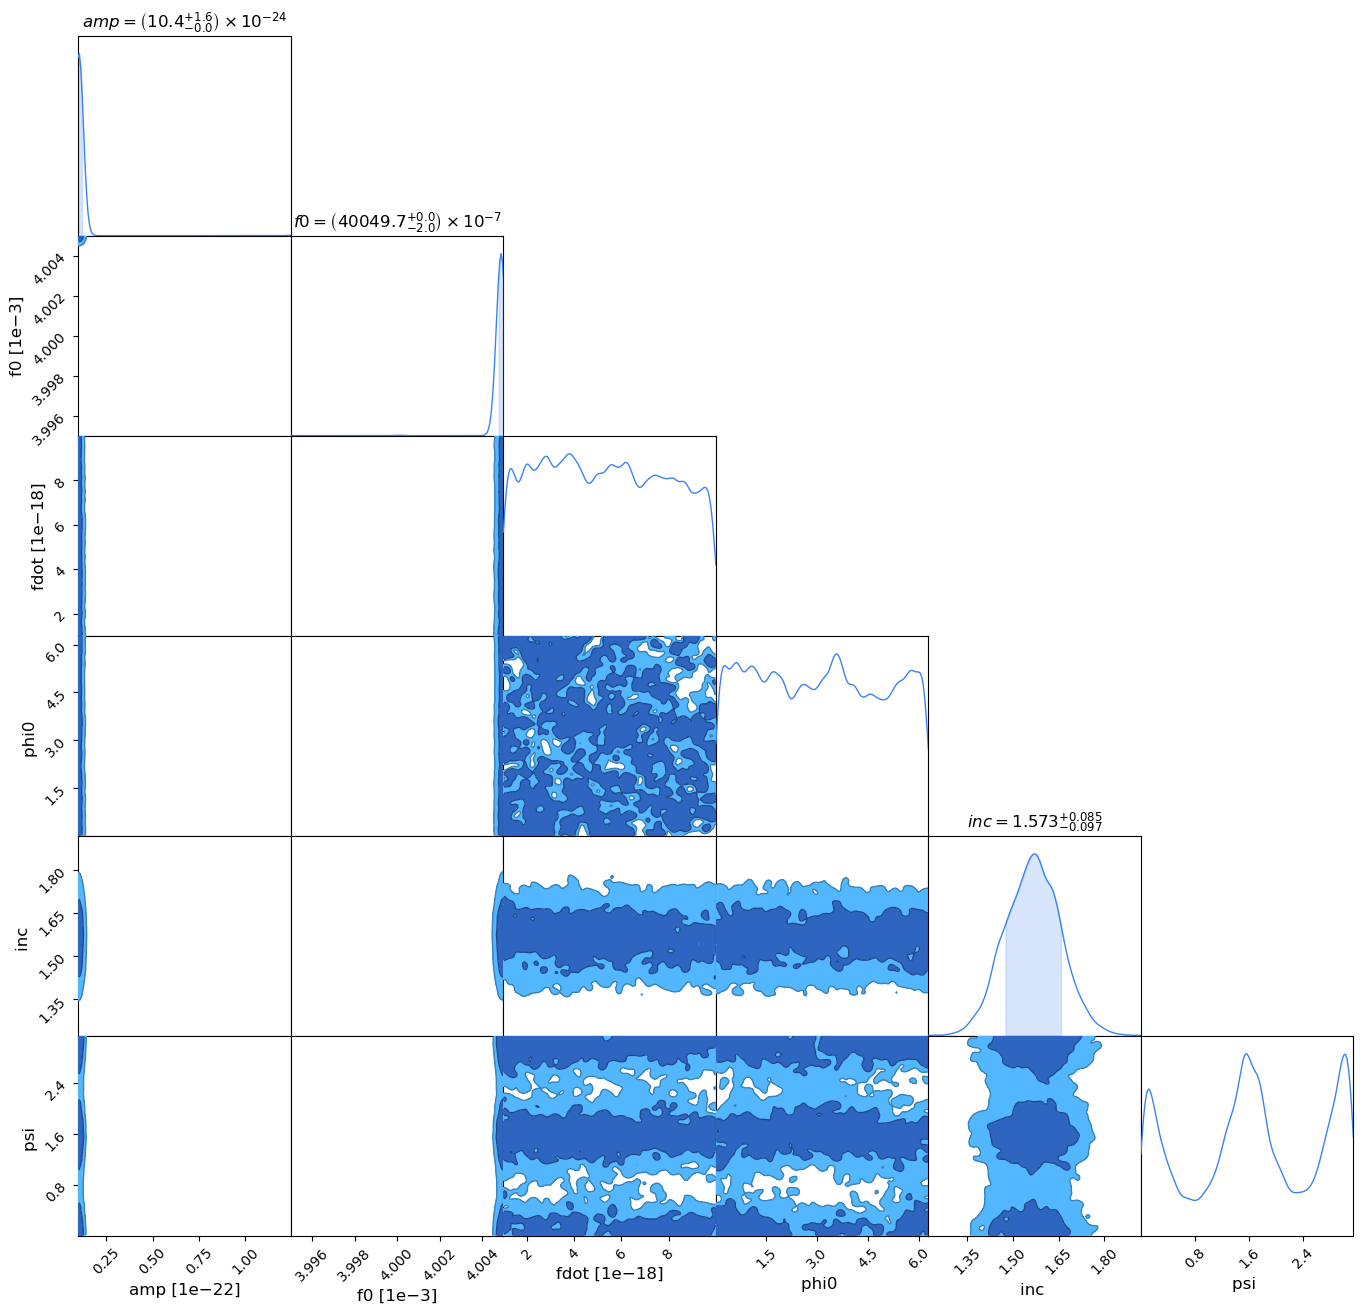

In [186]:
cold_chain = sampler.get_chain()["gb"][:, 0, :, 0].reshape(-1, 6)
c = ChainConsumer()

df1 = pd.DataFrame({name: val for name, val in zip(["amp", "f0", "fdot", "phi0", "inc", "psi"], cold_chain.T)}) 
c.add_chain(Chain(samples=df1, name=str(chain_i)))
fig = c.plotter.plot()

In [188]:
sampler.get_log_like()[-1, 0]

array([-19.21780592, -18.42097722, -18.43541785, -16.74901459,
       -20.31196987, -17.85264643, -15.55567728, -17.42619808,
       -15.85446004, -19.87508393, -16.98122712, -16.23934888,
       -18.30920452, -19.33481611, -18.04668737, -17.91315811,
       -15.94480364, -16.84607867, -18.47435225, -17.00908207,
       -21.15313913, -16.73840305, -17.24786924, -16.08364133])

## Task 3: RJ with GBs

In [231]:
def fill_template(template, A, E, freqs, Tobs, dt):
    lowest_start_ind = int(1e10)
    highest_end_ind = -1
    for i in range(A.shape[0]):
        start_ind = gb.start_inds[i]
        end_ind = start_ind + N_wave
        
        assert end_ind - start_ind == gb.freqs.shape[1]
        template[0, start_ind:end_ind] += A[i]
        template[1, start_ind:end_ind] += E[i]

def generate_global_template(template, params_all, Tobs, dt):
    gb.run_wave(*params_all.T, T=Tobs, dt=dt, N=N_wave)  # T=Tobs, oversample=4)
    fill_template(template, gb.A, gb.E, gb.freqs, Tobs, dt)
    
def global_log_likelihood(params_all, analysis, Tobs, dt, default_values):
    input_parameters = np.zeros((params_all.shape[0], 9))
    input_parameters[:, np.array([0, 1, 2, 4, 5, 6])] = params_all
    input_parameters[:, np.array([7, 8])] = default_values
    # print(input_parameters)
    
    template = np.zeros_like(analysis.data_res_arr[:])

    generate_global_template(template, input_parameters, Tobs, dt)
    template_in = DataResidualArray(template, f_arr=f_arr)
    ll = analysis.template_likelihood(template_in)
    return ll

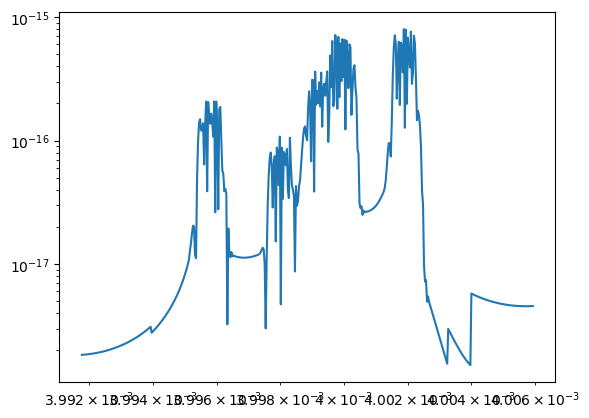

In [232]:
injection_params_all = priors["gb"].rvs(size=5)
input_parameters = np.zeros((injection_params_all.shape[0], 9))
input_parameters[:, np.array([0, 1, 2, 4, 5, 6])] = injection_params_all
input_parameters[:, np.array([7, 8])] = default_values
data = np.zeros((2, len(f_arr)), dtype=complex)

generate_global_template(data, input_parameters, Tobs, dt)
inds = np.where(data[0])
plt.loglog(f_arr[inds], np.abs(data[0][inds]))

In [233]:
data_arr = DataResidualArray(data, f_arr=f_arr)
sens_mat = AE1SensitivityMatrix(f_arr)
analysis = AnalysisContainer(data_arr, sens_mat)

In [236]:
global_log_likelihood(injection_params_all[1:], analysis, Tobs, dt, default_values)

-75118.82089330978

In [241]:
from eryn.moves import GaussianMove

In [251]:
nleaves_max = {"gb": 10}
nleaves_min = {"gb": 0}
ndims = {"gb": 6}

nwalkers = 14
ntemps = 12

factor = 0.001
cov    = {"gb": np.diag(np.array([1., 1e-9, 1., 1., 1., 1.])) * factor}
moves = GaussianMove(cov)

sampler_rj = EnsembleSampler(
    nwalkers,
    ndims,
    global_log_likelihood,
    priors,
    branch_names=["gb"],
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    args=(analysis, Tobs, dt, default_values),
    rj_moves=True,
    moves=moves,
    tempering_kwargs=dict(ntemps=ntemps)
)

In [ ]:
start_points = {"gb": priors["gb"].rvs(size=(ntemps, nwalkers, nleaves_max["gb"]))}
inds_tmp = np.zeros((ntemps, nwalkers, nleaves_max["gb"]), dtype=bool)
inds_tmp[:, :, 1] = True

start_state = State(start_points, inds={"gb": inds_tmp})

nsteps = 10
sampler_rj.run_mcmc(start_state, nsteps, progress=True)

  0%|                                                    | 0/10 [00:00<?, ?it/s]